<a id='8'></a> 
# Project description.

## Purpose of the project.

The purpose of this project is to conduct an Exploratory Data Analysis of the stud_math.csv dataset to make the dataset more suitable for machine learning. 

## Tasks.

Steps taken in order to complete the project:

<a href='#1'>1. Initial data review.

<a href='#2'>2. Evaluation of numerical data distribution; detecting and eliminating errors/outliers.  

<a href='#3'>3. Correlation analysis of numeric data.

<a href='#4'>4. Visual analysis of categorical data, evaluating the quantity of unique values. 

<a href='#5'>5. Applying t-test to categorical and mixed data.

<a href='#6'>6. Replacing empty values.  
    
<a href='#7'>7. Conclusion. 

### Libraries and optional settings.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50)  

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [4]:
stud_df = pd.read_csv('stud_math.csv')

### Useful functions

In [21]:
def first_look(df: pd.DataFrame, column: object, outlier_bounds: dict, descriptions: dict):
    '''
    Variables review function
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'): #Check if data type is a <str>
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print percentage of missing values
        misses = (1 - (df[column].count() / df.shape[0]))
        print('The percentage amount of missing values is: ', round(misses*100, 2), "%")
    else:
        plot_df = pd.DataFrame({'Distribution': df[column]})
        if search_mistakes(df, column, outlier_bounds):
            low, high = IQR_outlier(df, column, verbose=False)
            plot_df['Distribution within IQR range'] = df.loc[df.loc[:,column].between(low, high)][column]
        # Plot graphs
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print percentage of missing values
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Percentage of missing values : ', round(misses*100, 2), "%")


def search_mistakes(df: pd.DataFrame, column: object, outlier_bounds: dict) -> bool:
    '''
    The function checks for errors in the data.
    '''
    if column not in list(outlier_bounds.keys()):
        low, high = IQR_outlier(df, column, verbose=False)
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('The amount of outliers found: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nFirst 10:')
            display(out_df[:10])
            return True
        else:
            print('No outliers')
    else:
        low, high = outlier_bounds[column][0], outlier_bounds[column][1]
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('The amount of errors found: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nFirst 10:')
            display(out_df[:10])
            return True
        else:
            print('No errors')
                    


def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Function that displays IQR information:
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('First quantile: {},'.format(perc25)[:-1], 'Third quantile: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Outliers are located outside of the following range: [{f}, {l}].".format(f=low, l=high))
    return (low, high)


def fill_na(df: pd.DataFrame, column: object, method='auto') -> pd.Series:
    '''
    Function for filling missing values:
    Options for method parameter:
    mode - fills missing values with the most frequent value in a column.
    median - fills missing values with the median value.
    density - fills missing values with weighed parameters to ensure the distribution stays the same.
    auto - fills missing values with the median value in numerical columns, and with "density" in categorical and mixed columns. для численных переменных медиана, для номинативных и смешанных density
    '''
    if method=='auto':
        if (df[column].dtypes == np.dtype('O')) and (df[column].nunique()<10):
            prob = df[column].value_counts(normalize=True)
            ind = df[df[column].isna()==True].index
            fill_list = pd.Series(random.choices(prob.index, prob, k=df[column].isna().sum()))
            fill_list.index = ind
            return df[column].fillna(fill_list)
        else:
            median = df[column].median()
            return df[column].fillna(median)
    elif method=='mode':
        mode = df[column].mode()[0]
        return df[column].fillna(mode)
    elif method=='median':
        median = df[column].median()
        return df[column].fillna(median) 
    elif method=='density': 
        prob = df[column].value_counts(normalize=True)
        ind = df[df[column].isna()==True].index
        fill_list = pd.Series(random.choices(prob.index, prob, k=df[column].isna().sum()))
        fill_list.index = ind
        return df[column].fillna(fill_list)
    else:
        raise  NameError('method parameter can only take the following arguments: mode, median, density, auto')

        
def get_boxplot(df: pd.DataFrame, column: object, ax_y='score') -> None:
    '''
    Boxplot function for categorical and mixed data.
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    cnt = df[column].value_counts()
    medians = stud_df.groupby([column])[ax_y].median()
    vertical_offset = stud_df.groupby([column])[ax_y].median() * 0.12
    x=stud_df[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick], 
                    horizontalalignment='center',size=15, color='w',weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()



def get_stat_dif(df: pd.DataFrame, column: object, target='score') -> bool:
    '''
    T-test function for categorical and mixed data.
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(), 
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Bonferroni correction
            print('The following column showed statistically significant results: ', column)
            return True
            break

<a id='1'></a> 
## Initial data review

In [22]:
stud_df.head()

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [23]:
stud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

The dataset contains information about 395 students. All columns except the first three (shool, sex, age) contain missing values. There are 17 categorical columns and 13 numeric columns in the dataset.

Some of the numeric columns in fact represent structured categorical data, where categorical values are "encoded"/categorized  with a preset numeric range.  
Thus, there are only three columns with actual numeric values: "age", "absences" and "score", where score is a target variable.

In [24]:
# Bring column names to a standard form:
stud_df.columns = [i.lower() for i in stud_df.columns]
stud_df.rename({'studytime, granular': 'studytime_granular'}, inplace=True, axis=1)

In [25]:
#Check the dataset for duplicates:
if len(stud_df)>len(stud_df.drop_duplicates()):
    print('Duplicates are present')
    display(stud_df[stud_df.duplicated()])
else:
    print('No duplicates')


No duplicates


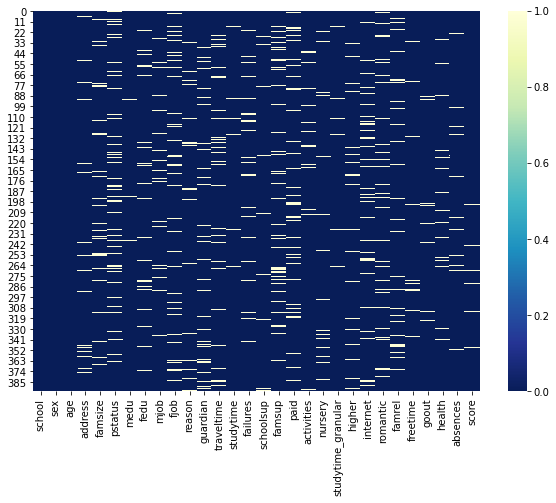

In [26]:
# Check distribution of missing values. 
plt.figure(figsize=(10, 7))# size of a heatmap
sns.heatmap(stud_df.isnull(), cmap="YlGnBu_r");

As we can see missing values are not concentrated in any particular row, but rather distributed evenly throughout the dataset, therefore deleting rows with missing values is not a good option. 

In [27]:
# Find the maximum amount of missing values per row:
Count_rows = stud_df.apply(lambda x: sum(x.isnull()), axis=1).value_counts()
percent_nans=round(pd.Series(Count_rows.index/stud_df.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(stud_df.apply(lambda x: sum(x.isnull()), axis=1))/stud_df.shape[1]
print('Maximum amount of missing values per row is ', round(misses*100, 2), "%")
pd.DataFrame({'Occurence count': Count_rows, 
              'Missing values count': Count_rows.index,
              'Missing values per row "%" ': percent_nans}).sort_values('Missing values count', ascending=False).reset_index().drop('index',axis=1)

Maximum amount of missing values per row is  20.0 %


,Occurence count,Missing values count,"Missing values per row ""%"""
0,2,6,20.0 %
1,5,5,17.0 %
2,15,4,13.0 %
3,47,3,10.0 %
4,131,2,7.0 %
5,97,1,3.0 %
6,98,0,0.0 %


Maximum missing value count in particular rows is not significant enough to delete those rows. 

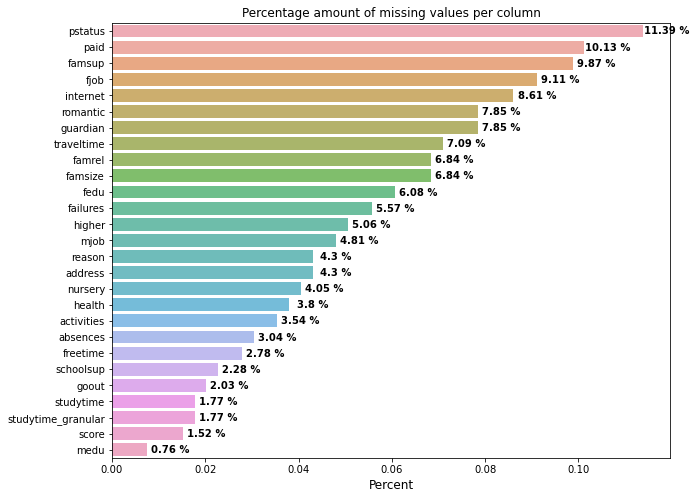

In [28]:
# Count the percentage amount of missing values per column: 
per_nans = pd.DataFrame(1-stud_df.count()/stud_df.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
# Plot a graph of the percentage amount of missing values per column:
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Percentage amount of missing values per column')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

<a id='2'></a> 
## Evaluation of numerical data distribution; detecting and eliminating errors/outliers.

In [29]:
# Declare a dictionary with column names and column descriptions:
descriptions = {
    "school": "Abbreviations of schools where students study",
    "sex": "Student's gender ('F' - female, 'M' - male)",
    "age": "Student's age (from 15 to 22)",
    "address": "Student's residence location ('U' - urban, 'R' - rural)",
    "famsize": "Family size ('LE3' <= 3, 'GT3' >3)",
    "pstatus": "Parents' relationship status ('T' - together 'A' - apart)",
    "medu": "Mother's level of education (0 - none, 1 - 4 grades, 2 - 5-9 grades, 3 - high school or vocational education, 4 - higher education)",
    "fedu": "Father's level of education (0 - none, 1 - 4 grades, 2 - 5-9 grades, 3 - high school or vocational education, 4 - higher education)",
    "mjob": "Mother's job ('teacher', 'health', 'services', 'at_home' , 'other')",
    "fjob": "Father's job ('teacher', 'health', 'services', 'at_home' , 'other)",
    "reason": "The reason why a particular school was chosen ('home' - close to the house, 'reputation' - school's reputation, 'course' - educational program, 'other')",
    "guardian": "Custodial parent ('mother', 'father', 'other')",
    "traveltime": "Travel time to school (1 - <15 mins., 2 - 15-30 mins., 3 - 30-60 mins., 4 - >60 mins.)",
    "studytime": "Extra time spent on studying per week (1 - <2 hours, 2 - 2-5 hours, 3 - 5-10 hours, 4 - >10 hours)",
    "failures": "Failures outside of school (n, if 1<=n<=3, else 0)",
    "schoolsup": "Academic suppport (yes/no)",
    "famsup": "Educational support from family (yes/no)",
    "paid": "Extra math classes (yes/no)",
    "activities": "Extracurricular activities (yes/no)",
    "nursery": "Attended kinergarten (yes/no)",
    "higher": "Student wants to pursue higher education (yes/no)",
    "internet": "Student has internet access at home (yes/no)",
    "romantic": " Student is in a romantic relationship (yes/no)",
    "famrel": "Family relationship (from 1 - 'very bad' to 5 - 'very good')",
    "freetime": "Free time after school (from 1 - 'very little' to 5 - 'a lot')",
    "goout": "Amount of time spent with friends (from 1 - 'very little' to 5 - 'a lot')",
    "health": "Current health condition (from 1 - 'very bad' to 5 - 'very good')",
    "absences": "School absences",
    "score": "Final math exam scores"
}

In [30]:
# Declare a dictionary with set value ranges for particular columns (based on column descriptions above)
outline_bounds = {
    "age": [15, 22],
    "Medu": [0, 4],
    "Fedu": [0, 4],
    "traveltime": [1, 4],
    "studytime": [1, 4],
    "failures": [0, 3],
    "famrel": [1, 5],
    "freetime": [1, 5],
    "goout": [1, 5],
    "health": [1, 5],
    'score': [0,100]
}

### school

Abbreviations of schools where students study

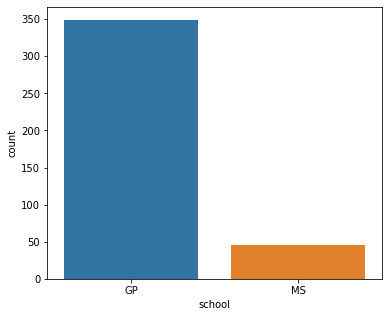

The percentage amount of missing values is:  0.0 %


### sex

Student's gender ('F' - female, 'M' - male)

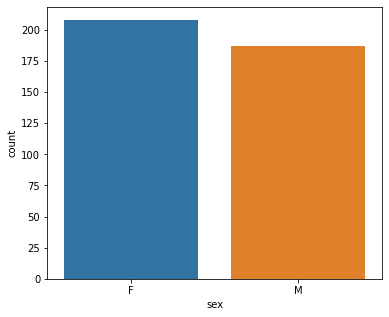

The percentage amount of missing values is:  0.0 %


### age

Student's age (from 15 to 22)

No errors


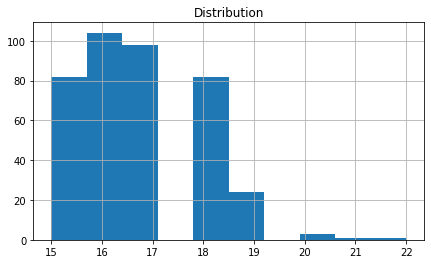

Percentage of missing values :  0.0 %


### address

Student's residence location ('U' - urban, 'R' - rural)

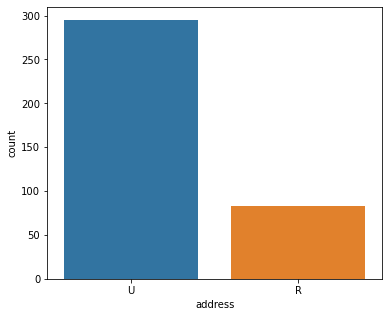

The percentage amount of missing values is:  4.3 %


### famsize

Family size ('LE3' <= 3, 'GT3' >3)

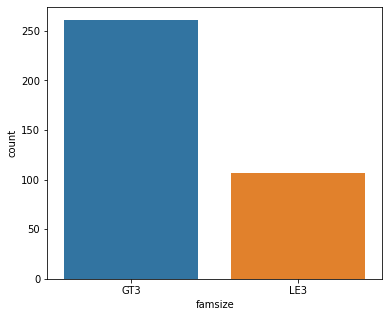

The percentage amount of missing values is:  6.84 %


### pstatus

Parents' relationship status ('T' - together 'A' - apart)

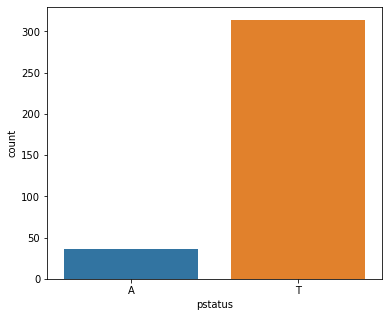

The percentage amount of missing values is:  11.39 %


### medu

Mother's level of education (0 - none, 1 - 4 grades, 2 - 5-9 grades, 3 - high school or vocational education, 4 - higher education)

No outliers


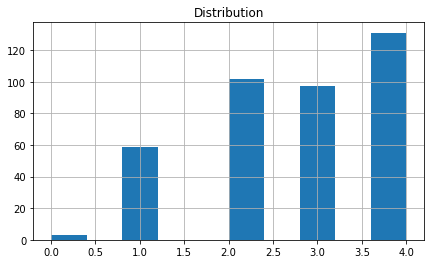

Percentage of missing values :  0.76 %


### fedu

Father's level of education (0 - none, 1 - 4 grades, 2 - 5-9 grades, 3 - high school or vocational education, 4 - higher education)

The amount of outliers found:  3


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
171,GP,M,16,U,GT3,T,1.0,0.0,other,other,reputation,mother,2.0,2.0,NaN,no,yes,yes,yes,yes,-6.0,NaN,yes,yes,4.0,3.0,2.0,3.0,2.0,80.0


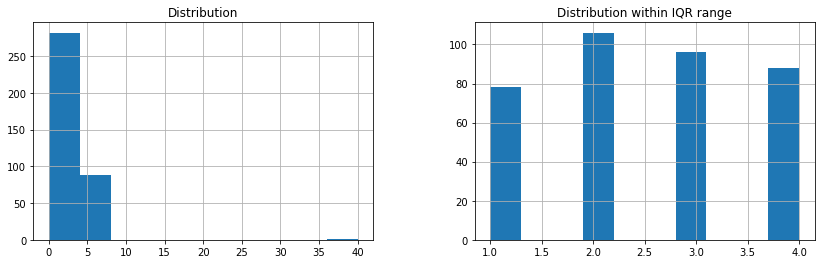

Percentage of missing values :  6.08 %


### mjob

Mother's job ('teacher', 'health', 'services', 'at_home' , 'other')

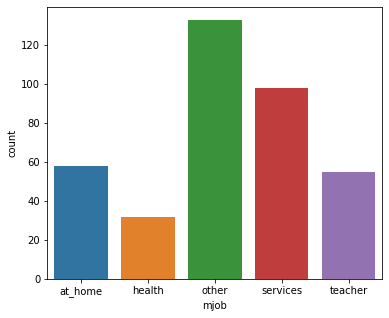

The percentage amount of missing values is:  4.81 %


### fjob

Father's job ('teacher', 'health', 'services', 'at_home' , 'other)

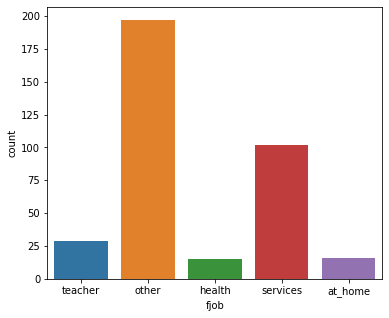

The percentage amount of missing values is:  9.11 %


### reason

The reason why a particular school was chosen ('home' - close to the house, 'reputation' - school's reputation, 'course' - educational program, 'other')

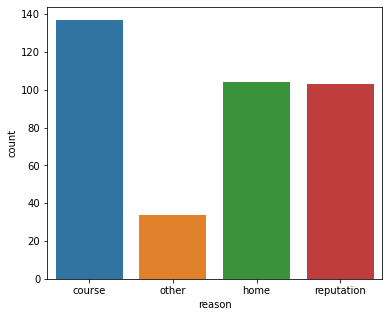

The percentage amount of missing values is:  4.3 %


### guardian

Custodial parent ('mother', 'father', 'other')

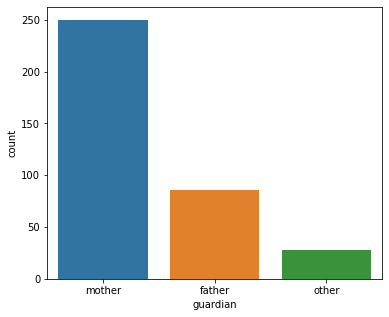

The percentage amount of missing values is:  7.85 %


### traveltime

Travel time to school (1 - <15 mins., 2 - 15-30 mins., 3 - 30-60 mins., 4 - >60 mins.)

No errors


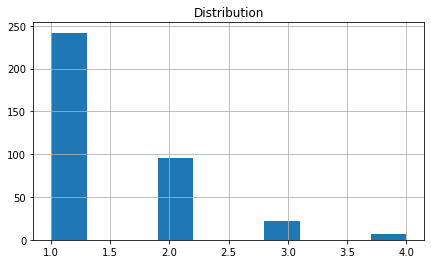

Percentage of missing values :  7.09 %


### studytime

Extra time spent on studying per week (1 - <2 hours, 2 - 2-5 hours, 3 - 5-10 hours, 4 - >10 hours)

No errors


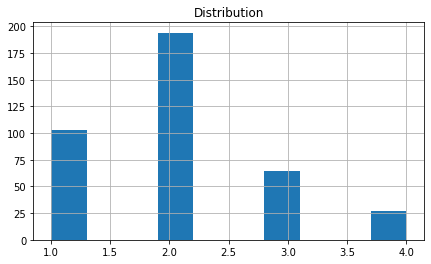

Percentage of missing values :  1.77 %


### failures

Failures outside of school (n, if 1<=n<=3, else 0)

No errors


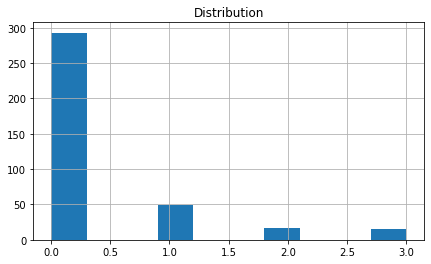

Percentage of missing values :  5.57 %


### schoolsup

Academic suppport (yes/no)

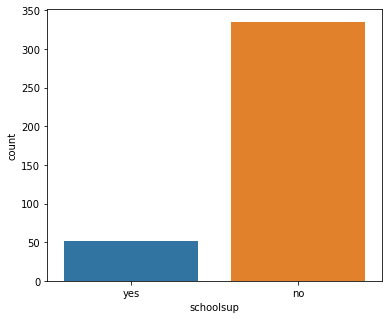

The percentage amount of missing values is:  2.28 %


### famsup

Educational support from family (yes/no)

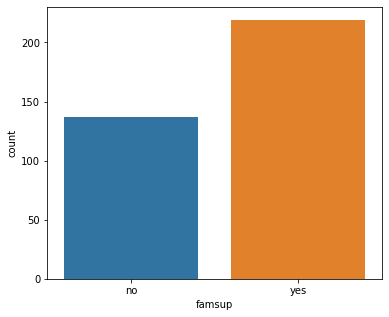

The percentage amount of missing values is:  9.87 %


### paid

Extra math classes (yes/no)

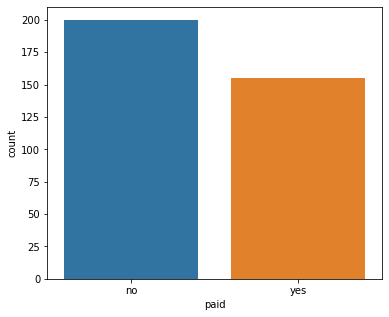

The percentage amount of missing values is:  10.13 %


### activities

Extracurricular activities (yes/no)

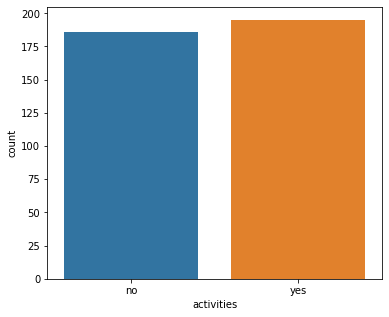

The percentage amount of missing values is:  3.54 %


### nursery

Attended kinergarten (yes/no)

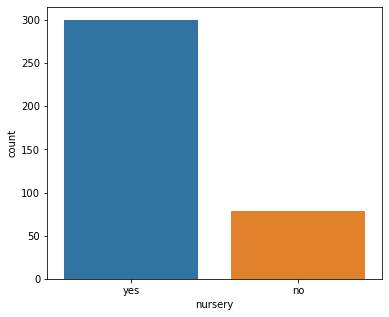

The percentage amount of missing values is:  4.05 %


### studytime_granular

The amount of outliers found:  27

First 10:


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
69,GP,F,15,R,LE3,T,3.0,1.0,other,other,reputation,father,2.0,4.0,0.0,no,yes,no,no,no,-12.0,yes,yes,no,4.0,4.0,2.0,3.0,12.0,80.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
71,GP,M,15,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,no,no,yes,-12.0,yes,yes,no,3.0,3.0,3.0,3.0,0.0,50.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0


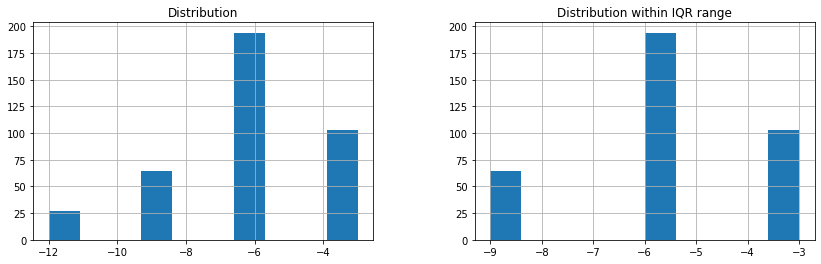

Percentage of missing values :  1.77 %


### higher

Student wants to pursue higher education (yes/no)

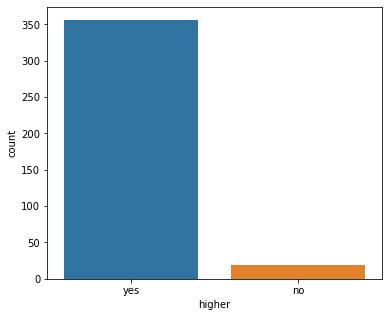

The percentage amount of missing values is:  5.06 %


### internet

Student has internet access at home (yes/no)

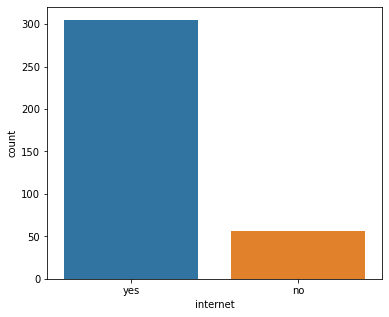

The percentage amount of missing values is:  8.61 %


### romantic

 Student is in a romantic relationship (yes/no)

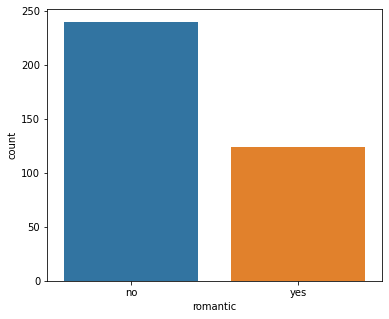

The percentage amount of missing values is:  7.85 %


### famrel

Family relationship (from 1 - 'very bad' to 5 - 'very good')

The amount of errors found:  1


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


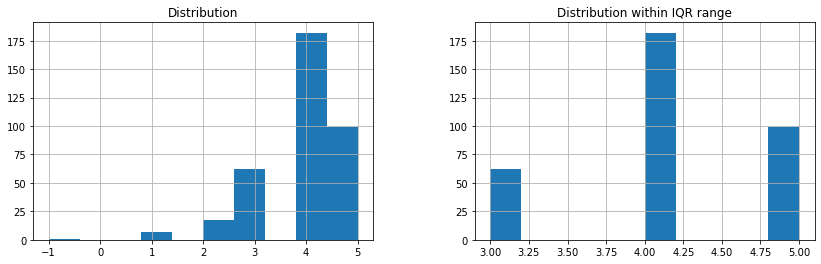

Percentage of missing values :  6.84 %


### freetime

Free time after school (from 1 - 'very little' to 5 - 'a lot')

No errors


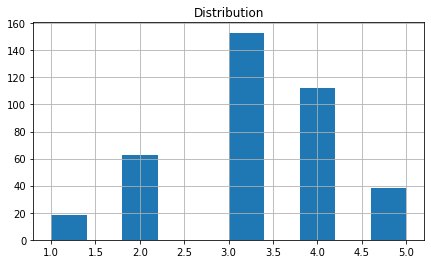

Percentage of missing values :  2.78 %


### goout

Amount of time spent with friends (from 1 - 'very little' to 5 - 'a lot')

No errors


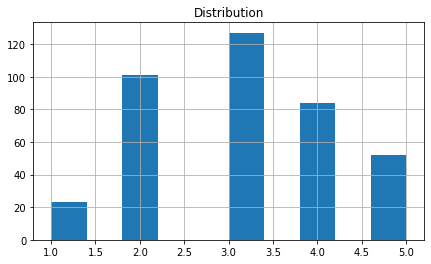

Percentage of missing values :  2.03 %


### health

Current health condition (from 1 - 'very bad' to 5 - 'very good')

No errors


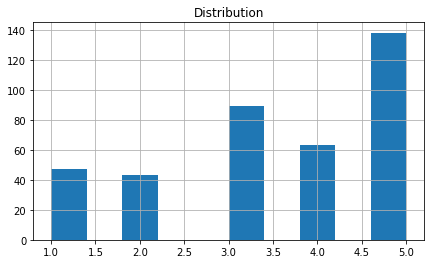

Percentage of missing values :  3.8 %


### absences

School absences

The amount of outliers found:  17

First 10:


,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


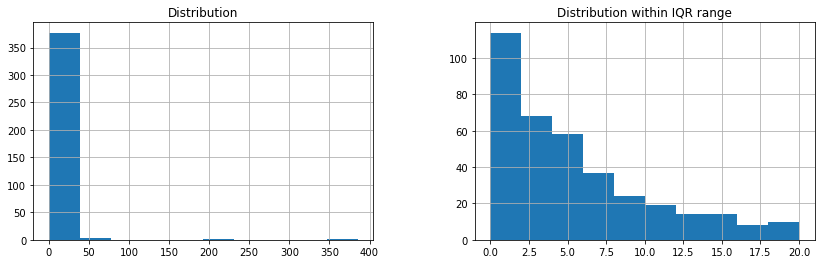

Percentage of missing values :  3.04 %


### score

Final math exam scores

No errors


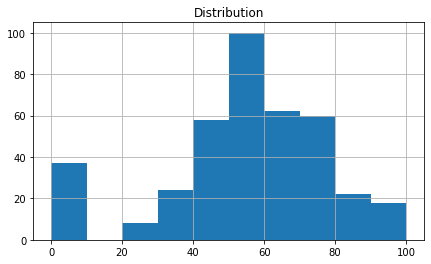

Percentage of missing values :  1.52 %


In [31]:
for col in stud_df.columns:
    first_look(stud_df, col, outline_bounds, descriptions)

### Interim findings:  
Data is rather clean, however certain problematic details/aspects were found:
* Certain columns(higher, pstatus, school, famrel) contain imbalanced data; 
* Based on the information from the age column, it makes sense to create a new variable (young/old) to represent the students of a normal age, and the students whose age is older than normal.;
* A new value can be created based on schoolsup and famsup data. The value would represent presence or absence of academic support in general; 
* fedu and famrel columns contain out-of-range values;
* absences and studytime_granular columns contain outliers; 
* Target variable score contains 1,5% of missing values;  
* Distribution of values in studytime_granular column is almost identical to distribution in studytime column.

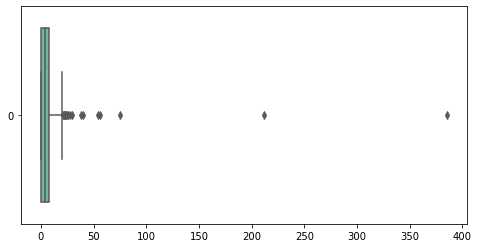

In [32]:
#Examine the absences column:
plt.figure(figsize=(8, 4))
sns.boxplot(data=stud_df['absences'], orient="h",
                 palette="Set2", whis=1.5);

Only 2 values shown on the graph are considerably outside of the normal range. Since the dataset at hand is rather small, it would be a better option to replace the 2 outliers with the median value for the column.  

In [34]:
# Data processing based on interim findings:
stud_df.fedu = stud_df.fedu.replace(40,4)
stud_df.famrel = stud_df.famrel.replace(-1,1)
stud_df.absences = stud_df.absences.apply(lambda x: stud_df.absences.median() if x>100 else x)
stud_df['age_cat'] = stud_df.age.apply(lambda x: 'young' if x<18 else 'old')
stud_df['is_sup'] = np.where((stud_df.schoolsup == 'yes') | (stud_df.famsup == 'yes'), 'yes', 'no')
stud_df.dropna(subset=['score'], inplace=True)


Detailed review of the target variable "score": 

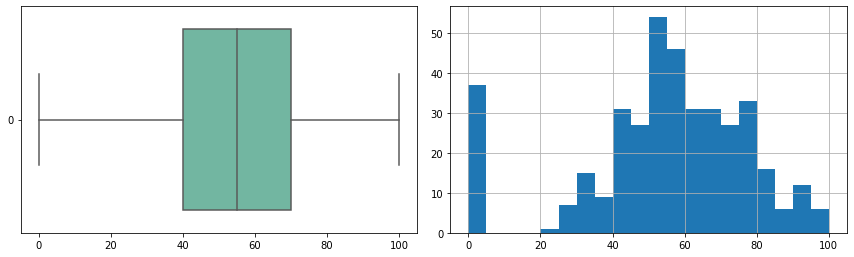

Ошибки не обнаружены


In [16]:
# Score graphs
fig, axes = plt.subplots(ncols=2, figsize=(6, 4))

sns.boxplot(data=stud_df['score'], orient="h",
                 palette="Set2", whis=1.5, ax=axes[0]);
stud_df.score.hist(bins=20, ax=axes[1])
fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
plt.show()
search_mistakes(stud_df, 'score',outline_bounds)

#### Findings:  

* More than 30 students received a "0" score
* No values between 0 and 20. Normal distributiond starts from 20.
* no errors, no outliers. 

Absence of values that are bigger than 0 but smaller than 20 can be explained by existence of a possible passing score, where any score less than "20" woud be considered "0" (a failure) by default.
Such considerable presence of "0" values in the score column seems questionable. However in the EDA stage it makes sense to keep 0 values in the dataset to see if the future ML model will be able to detect students prone to failure. 

<a id='3'></a> 
## Correlation analysis of numeric data.

Correlation analysis of numeric data will help to determine what columns should/should not be used for building a prospective ML model 

- **numeric variables** :

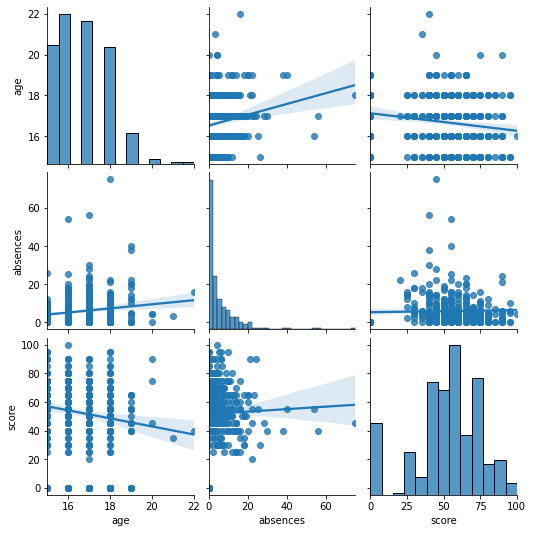

In [35]:
stud_num = ['age', 'absences', 'score']
sns.pairplot(stud_df[stud_num], kind='reg');

In [36]:
stud_df[stud_num].corr()

,age,absences,score
age,1.000000,0.169071,-0.155726
absences,0.169071,1.000000,0.030943
score,-0.155726,0.030943,1.000000


Linear correlation between "absences" and "score" is rather insignificant. The next step is to look for presence of curvilinear correlation. 

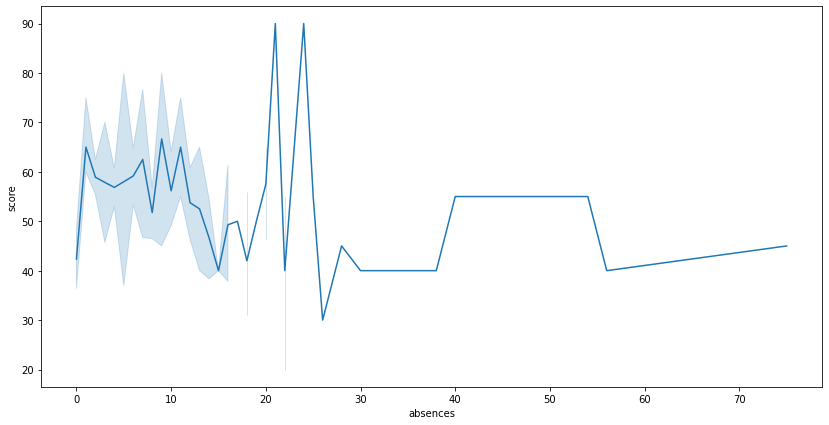

In [37]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=stud_df, x='absences', y='score');

Predictor 'absences' has a low statistical significance level. 

- **Numeric and mixded data correlation analysis**:

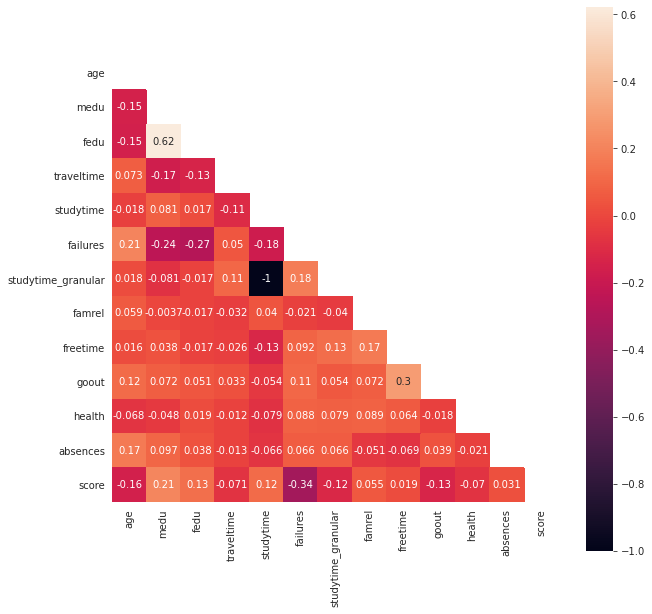

In [38]:
corr = stud_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

There is complete negative correlation between the "studytime_granular" and the "studytime" variables. Therefore studytime_granular column can't be considered informative and should be deleted. 
There is a strong linear correlation between "medu" and "fedu" variables. This can be used for:
* missing data reconstruction  
* creating a new variable based on the two existing variables

In [39]:
# Create a separate DataFrame with correlation values:
score_correlation_df = pd.DataFrame(stud_df.corr()["score"].values,
                                    index=stud_df.corr()["score"].index,
                                    columns=['correlation'])
score_correlation_df = score_correlation_df.drop("score")

score_correlation_df['correlation_amount'] = abs(
    score_correlation_df.correlation)
printmd("#### Correlation values in a descending order")
score_correlation_df.sort_values(by='correlation_amount', ascending=False)

#### Correlation values in a descending order

,correlation,correlation_amount
failures,-0.344338,0.344338
medu,0.213349,0.213349
age,-0.155726,0.155726
fedu,0.130923,0.130923
goout,-0.129685,0.129685
studytime,0.115741,0.115741
studytime_granular,-0.115741,0.115741
traveltime,-0.070559,0.070559
health,-0.070460,0.070460
famrel,0.055305,0.055305


Based on results from the table above, the parameters that impede on the score the most are:
- failures outside of school, 
- young age
- spending a lot of time with friends.
Surprisingly, the amount of absences and the amount of free time do not have a noticeable influence on the score. 
 For the purpose of data cleaning, columns with correlation value of less than 0.1 should be removed. 

In [47]:
#Data processing based on correlation analysis criteria:
stud_df.drop('studytime_granular', axis=1, inplace=True)
stud_df.drop(score_correlation_df[score_correlation_df.correlation_amount < 0.1].index, axis=1, inplace=True)
stud_df['p_edu'] = stud_df['fedu']+stud_df['medu']

<a id='4'></a>

## Visual analysis of  categorical data, evaluating the quantity of unique values.

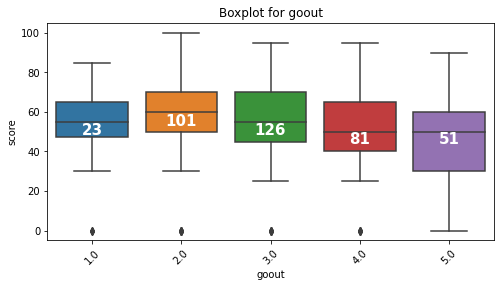

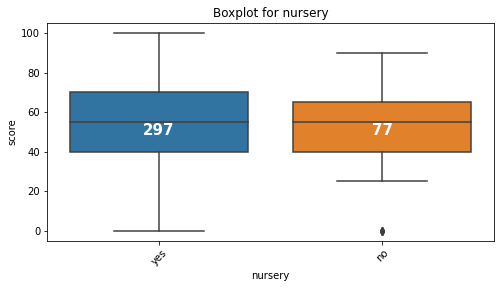

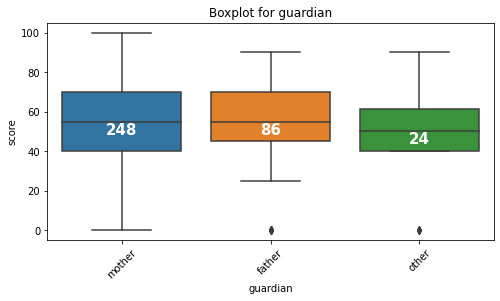

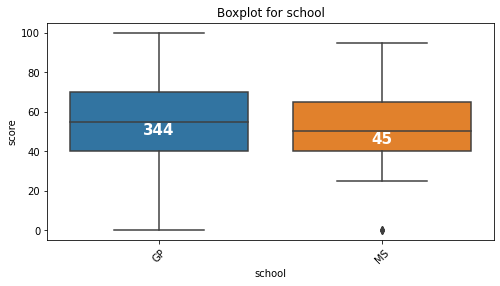

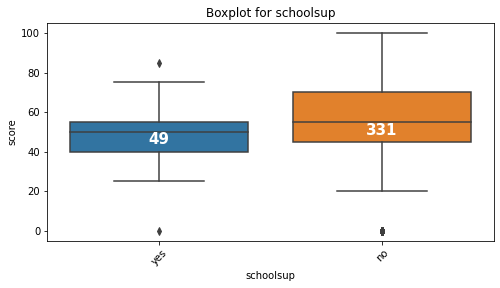

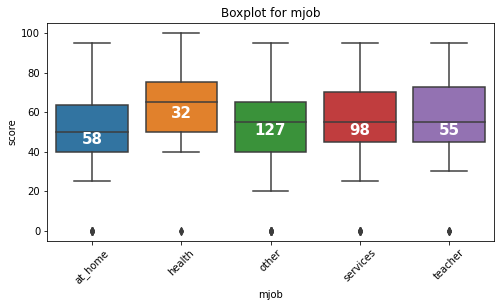

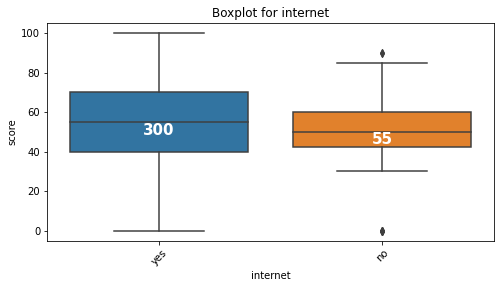

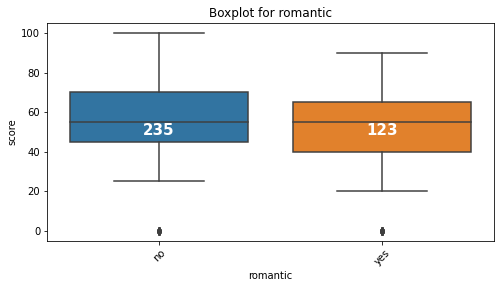

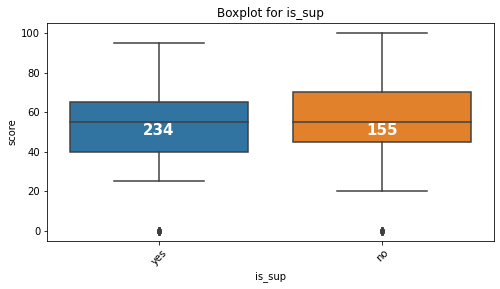

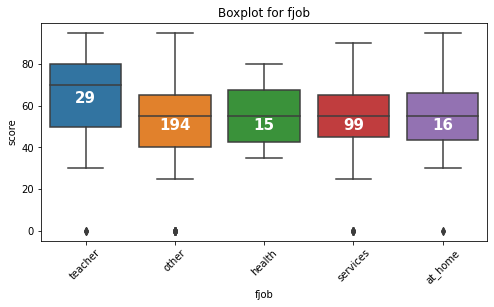

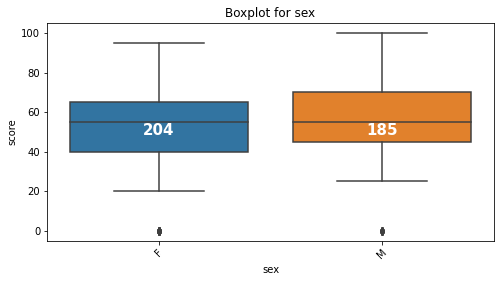

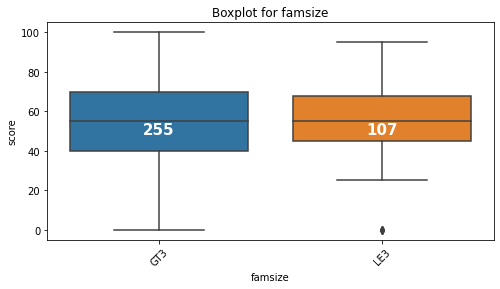

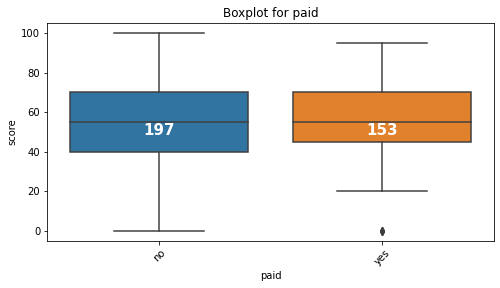

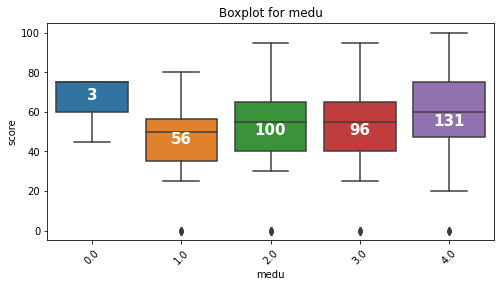

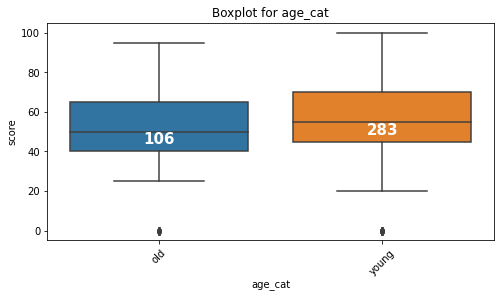

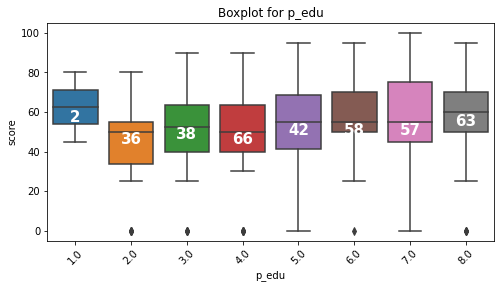

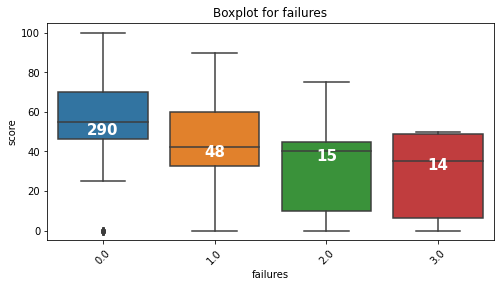

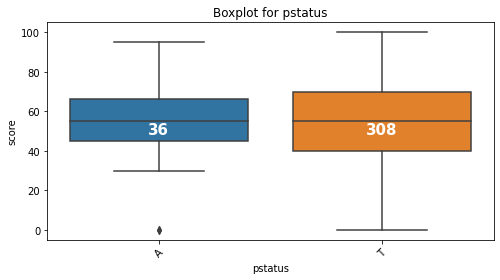

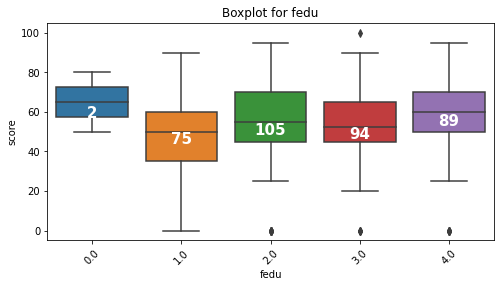

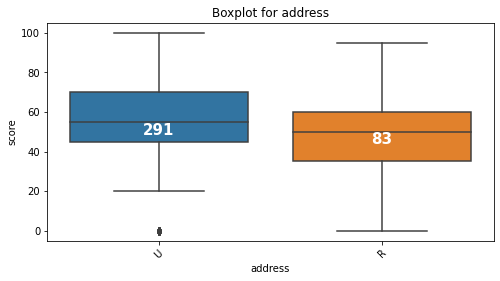

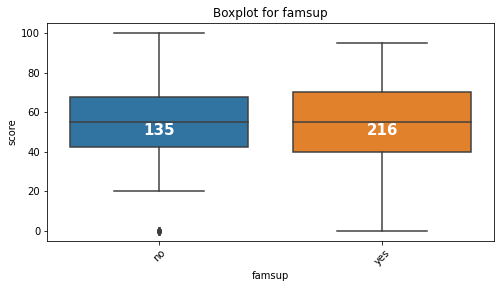

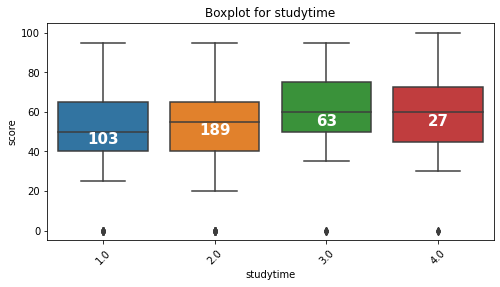

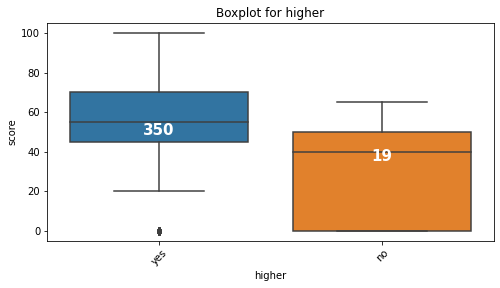

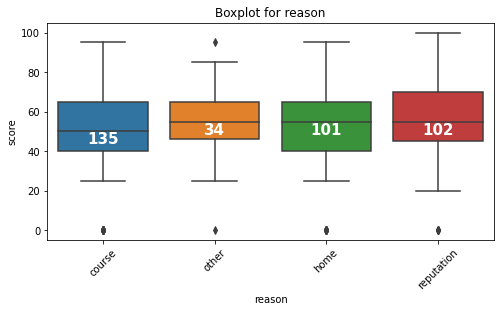

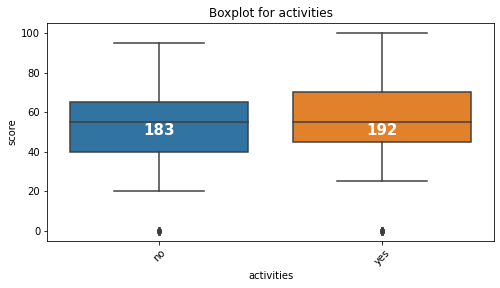

In [48]:
nom_cols = list(set(stud_df.columns) - set(['age', 'absences', 'score']))
for col in nom_cols:
    get_boxplot(stud_df, col)

In [51]:
stud_df['is_dad_teacher'] = stud_df.fjob.apply(lambda x: 1 if x=='teacher' else 0)

#### Interim findings:  
Upon boxplot graphs review the most useful predictors appear to be the following variables: 
* schoolsup  
* Fedu  
* P_edu
* failures  
* Mjob  
* Medu  
* is_dad_teacher  
* higher  
* age_cat  
* goout  
* school  
* address  
* studytime

<a id='5'></a>
## Applying t-test to categorical and mixed data. 

Use t-test on columns with categorical data to check if there are statistically significant results. The N0 hypothesis is that the score doesn't depend on categorical values distribution. 

In [49]:
nom_cols = list(set(stud_df.columns) - set(['age', 'absences', 'score']))
lst = []
for col in nom_cols:
    if get_stat_dif(stud_df, col):
        lst.append(col)

The following column showed statistically significant results:  goout
The following column showed statistically significant results:  mjob
The following column showed statistically significant results:  romantic
The following column showed statistically significant results:  sex
The following column showed statistically significant results:  paid
The following column showed statistically significant results:  medu
The following column showed statistically significant results:  age_cat
The following column showed statistically significant results:  p_edu
The following column showed statistically significant results:  failures
The following column showed statistically significant results:  fedu
The following column showed statistically significant results:  address
The following column showed statistically significant results:  higher


A t-test and a categorical data analysis using boxplot graphs are the two methods that should be regarded as complementary methods. Therefore, those parameterers that appear to be informative based on either of the methods, should be kept in the dataset during the EDA stage.

In [52]:
# Final version of a DataFrame:
list_columns = set(['schoolsup', 'fedu', 'p_edu', 'failures', 'mjob', 'medu', \
                    'is_dad_teacher', 'higher', 'age_cat',  'goout', 'school', 'address', 'studytime', 'age', 'score'] + lst)
stud_df = stud_df[list_columns]

In [27]:
stud_df.head()

,address,score,school,mjob,goout,medu,age,p_edu,schoolsup,studytime,sex,higher,failures,fedu,romantic,age_cat,is_dad_teacher,paid
0,U,30.0,GP,at_home,4.0,4.0,18,8.0,yes,2.0,F,yes,0.0,4.0,no,old,1,no
1,U,30.0,GP,at_home,3.0,1.0,17,2.0,no,2.0,F,yes,0.0,1.0,no,young,0,no
2,U,50.0,GP,at_home,2.0,1.0,15,2.0,yes,2.0,F,yes,3.0,1.0,NaN,young,0,NaN
3,U,75.0,GP,health,2.0,4.0,15,6.0,no,3.0,F,yes,0.0,2.0,yes,young,0,yes
4,U,50.0,GP,other,2.0,3.0,16,6.0,no,2.0,F,yes,0.0,3.0,no,young,0,yes


<a id='6'></a>
## Replacing missing values

The dataset at hand contains rather a small amount of missing values ~ 12%. 
To replace missing values the following approaches can be used:
- Replace missing values with weighed parameters to ensure the distribution stays the same 
- Replace missing values with the most frequent value in a column (mode)
- Replace missing values with the median value

In [53]:
# Replace missing values using a strong linear correlation approach.

stud_df.fedu = np.where(stud_df.fedu.isna(), stud_df.medu, stud_df.fedu)
stud_df.medu = np.where(stud_df.medu.isna(), stud_df.fedu, stud_df.medu)

#Use the median value to replace missing numerical data and weighed parameters to replace missing categorical and mixed data;
for col in stud_df.columns:
    stud_df[col] = fill_na(stud_df, col, method='auto')

<a id='7'></a>
## Conclusion.

**Findings based on the results of a conducted exploratory data analysis:**  
1. Data is relatively clean: 
* Amount of missing values per column varies from 1% to 11%. Three columns contain no missing values;
* Erroneous values were discovered in fedu and famrel columns. The errors were replaced with values that looked most logical in the particular situation;
* The absences column contained 2 abnormal values (>200), that were replaced with the median value. 
2. Upon detailed review of data distribution the following decisions were made: 
* Create an additional category "is.sup" that would show presence or absence of support in general;   
* Create an additional column "age_cat" that would divide students into "old" and "young" categories, where "old" category would unite all the students who are outside of the normal age range;
* Remove missing values from the target column "score";  
* Keep "0" values in the target column "score" for consequent analysis and verification of the possibility of using the values for  ML modeling.
3. Findings resulted from correlation analysis:
* Strong negative correlation was discovered between the columns "studytime" and "studytime_granular", therefore one of the columns (studytime_granular) was deleted since it was found uninformative;
* Linear correlation discovered between the columns "medu" and "fedu" helped create a new informative category and fill in missing values in the respective columns;  
* Variables with correlation coefficient of less than |0.1| were excluded from the list of prospective parameters for ML model building.
4. T-test and boxplot analysis of the categorical data helped point out the following important parameters:
age_cat, goout, sex, paid, is_dad_teacher, Mjob, failures, Medu, Fedu, address, romantic, schoolsup, school, studytime, higher, P_edu
**Conclusion:**  
The following parameters are recommended for ML modeling: 
sex, address, Mjob, schoolsup, paid, higher, romantic, age, Medu, Fedu, studytime, failures, goout 